# Stacked Bi-LSTM iter 2 
Here we train for a length of 150 units
Where the change is done in creating the list of patients \
Note: Here patients is list of Control subjects and patients1 is list of Parkinson patients

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras import utils as np_utils

from random import shuffle
from tensorflow.python.client import device_lib

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For wider plots
plt.rcParams["figure.figsize"] = (20,6)

# Take my NVidia GPU into use
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2"

In [3]:
files1 = glob.glob("./parkinsons/*Co*.txt")
files2 = glob.glob("./parkinsons/*Pt*.txt")
# files=files1+files2
# shuffle(files)

In [4]:
columns = ["elaps_time","L1", "L2","L3","L4","L5","L6","L7","L8","R1","R2","R3","R4","R5","R6","R7","R8","LTot","RTot"]

In [5]:
def getClassForHealthyOrNot(filename):
    if (filename.find("Co") >=0):
        return 0
    else:
        return 1


In [6]:
class Patient:
    def __init__(self,input_data,y):
        self.x = input_data
        self.y = y
        self.x_scaled = input_data

In [7]:
patients=[]
un_used_data=[]

for f in files1:
    #print(f"{i+1}. {file}")
    
    data_txt = pd.read_table(f,names=columns)
    data_txt.drop(['elaps_time'],inplace=True,axis=1)
    
    
    
    j=0
    ispark = getClassForHealthyOrNot(f)
    # print(ispark)
    while j < 12001:
        data = data_txt.iloc[j+1:j+151,:]
        
        if data.shape[0] == 150:
            patients.append( Patient(data, ispark) )
        
        j=j+75

In [8]:
patients1=[]
un_used_data1=[]

for f in files2:
    #print(f"{i+1}. {file}")
    
    data_txt = pd.read_table(f,names=columns)
    data_txt.drop(['elaps_time'],inplace=True,axis=1)
    
    
    
    j=0
    ispark = getClassForHealthyOrNot(f)
    # print(ispark)
    while j < 12001:
        data = data_txt.iloc[j+1:j+151,:]
        
        if data.shape[0] == 150:
            patients1.append( Patient(data, ispark) )
        
        j=j+75

In [9]:
len(patients)

13361

In [10]:
len(patients1)


29664

In [11]:
shuffle(patients)
shuffle(patients1)

In [12]:
train = patients[:int(len(patients)*0.8)]+patients1[:int(len(patients1)*0.8)]
test = patients[int(len(patients)*0.8):]+patients1[int(len(patients1)*0.8):]

In [13]:
print(len(train))
print(len(test))

34419
8606


In [14]:
shuffle(train)
shuffle(test)

In [15]:
train_concat=[]
for p in train:
    train_concat = train_concat+[p.x]

In [16]:
data_tr = pd.concat(train_concat,ignore_index=True)

In [17]:
scaler = StandardScaler()
scaler.fit_transform(data_tr)

array([[-0.45587084, -0.56198919, -0.52845803, ..., -0.76409095,
         1.34887398, -1.11487277],
       [-0.45587084, -0.56198919, -0.55169045, ..., -0.76409095,
         1.37743382, -1.11487277],
       [-0.45587084, -0.57725889, -0.55169045, ..., -0.76409095,
         1.38341779, -1.10805243],
       ...,
       [-0.64958142, -0.67523947, -0.64607215, ...,  0.45792515,
        -1.12468041,  0.71707044],
       [-0.64958142, -0.67523947, -0.64607215, ...,  0.51732871,
        -1.11760845,  0.74080522],
       [-0.64958142, -0.67523947, -0.64607215, ...,  0.66583761,
        -1.11760845,  0.79918733]])

In [18]:
i=0
wo_time_col=["L1", "L2","L3","L4","L5","L6","L7","L8","R1","R2","R3","R4","R5","R6","R7","R8","LTot","RTot"]
for obj in train:
    obj.x_scaled = pd.DataFrame(scaler.transform(obj.x),columns=wo_time_col)
    i=i+1

In [19]:
for obj in test:
    obj.x_scaled = pd.DataFrame(scaler.transform(obj.x),columns=wo_time_col)
    i=i+1

In [20]:
X_scaled_list_train=[]
Y_list_train=[]

for obj in train:
    X_scaled_list_train = X_scaled_list_train + [obj.x_scaled]
    Y_list_train = Y_list_train + [obj.y]
    
X_scaled_arr_train = np.array(X_scaled_list_train)
Y_arr_train = np.array(Y_list_train)

In [21]:
X_scaled_arr_train.shape

(34419, 150, 18)

In [22]:
Y_arr_train.shape

(34419,)

In [23]:
X_scaled_list_test=[]
Y_list_test=[]

for obj in test:
    X_scaled_list_test = X_scaled_list_test + [obj.x_scaled]
    Y_list_test = Y_list_test + [obj.y]
    
X_scaled_arr_test = np.array(X_scaled_list_test)
Y_arr_test = np.array(Y_list_test)

In [25]:
import numpy as np

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(80, dropout=0.3, 
                  return_sequences=True, 
                  input_shape=(X_scaled_arr_train.shape[1], X_scaled_arr_train.shape[2]))))
model.add(Bidirectional(LSTM(32, dropout=0.5,return_sequences=True)))
model.add(LSTM(24, dropout=0.2,return_sequences=True))
model.add(LSTM(12, dropout=0.2,return_sequences=False))
model.add(Dense(1, kernel_initializer='glorot_uniform', activation='relu'))
opt=tf.keras.optimizers.Adam(
    learning_rate=0.00005,
    name="Adam"
    )
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, mode='auto')
checkpoint = ModelCheckpoint("./Model/model_LSTM22.v", 
                             monitor='val_accuracy', verbose=1, save_best_only=True, 
                             save_weights_only=False)

In [ ]:
history = model.fit(X_scaled_arr_train,Y_arr_train,epochs=500,validation_split=0.2,batch_size=20,shuffle=True,callbacks=[early_stopping, checkpoint])

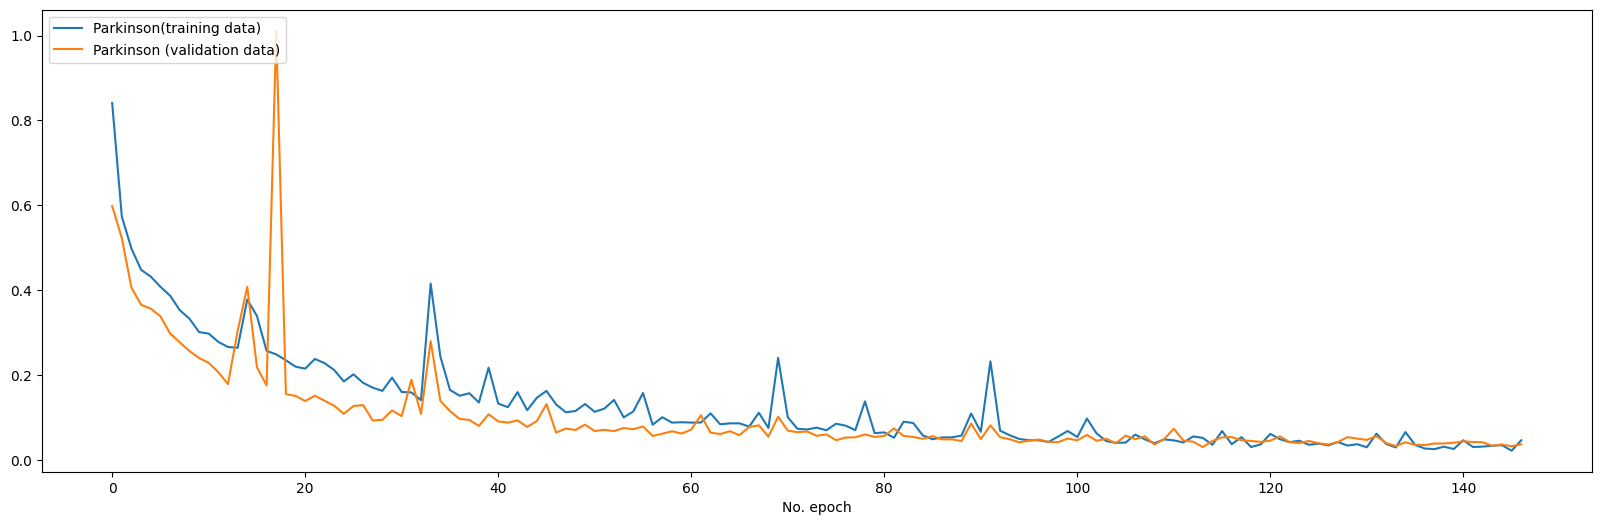

In [28]:
plt.plot(history.history['loss'], label='Parkinson(training data)')
plt.plot(history.history['val_loss'], label='Parkinson (validation data)')
plt.title('')
plt.ylabel('')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

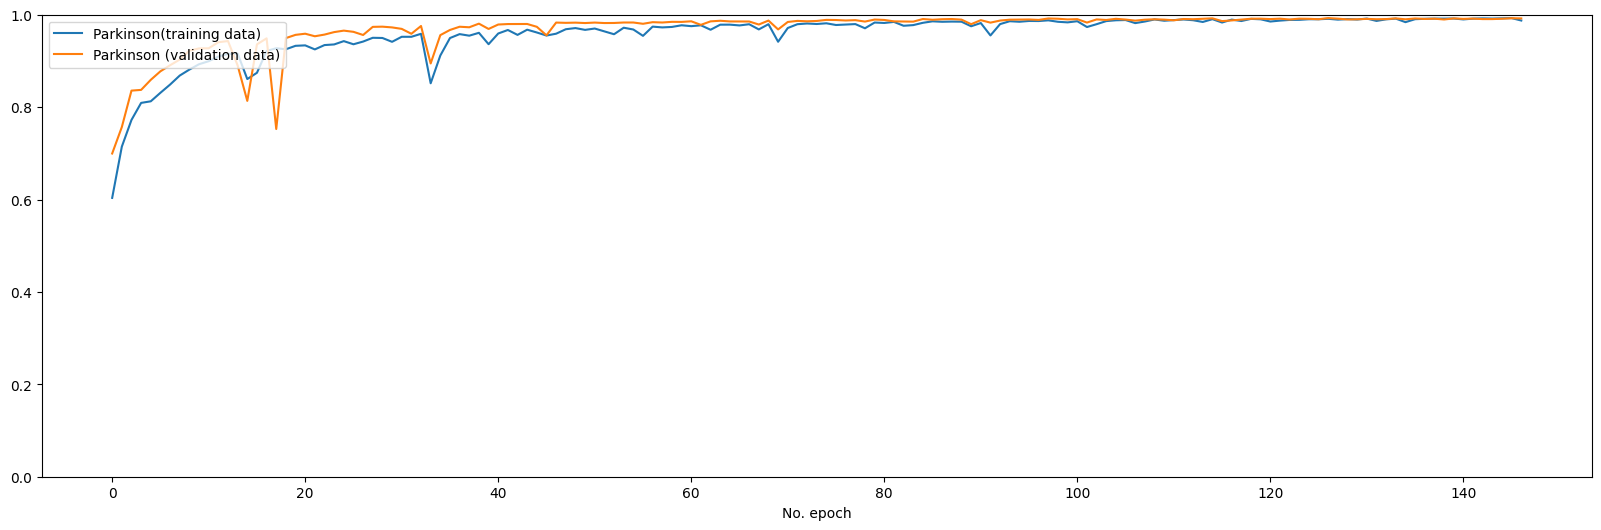

In [29]:
plt.plot(history.history['accuracy'], label='Parkinson(training data)')
plt.plot(history.history['val_accuracy'], label='Parkinson (validation data)')
plt.title('')
plt.ylabel('')
plt.ylim(0,1)
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

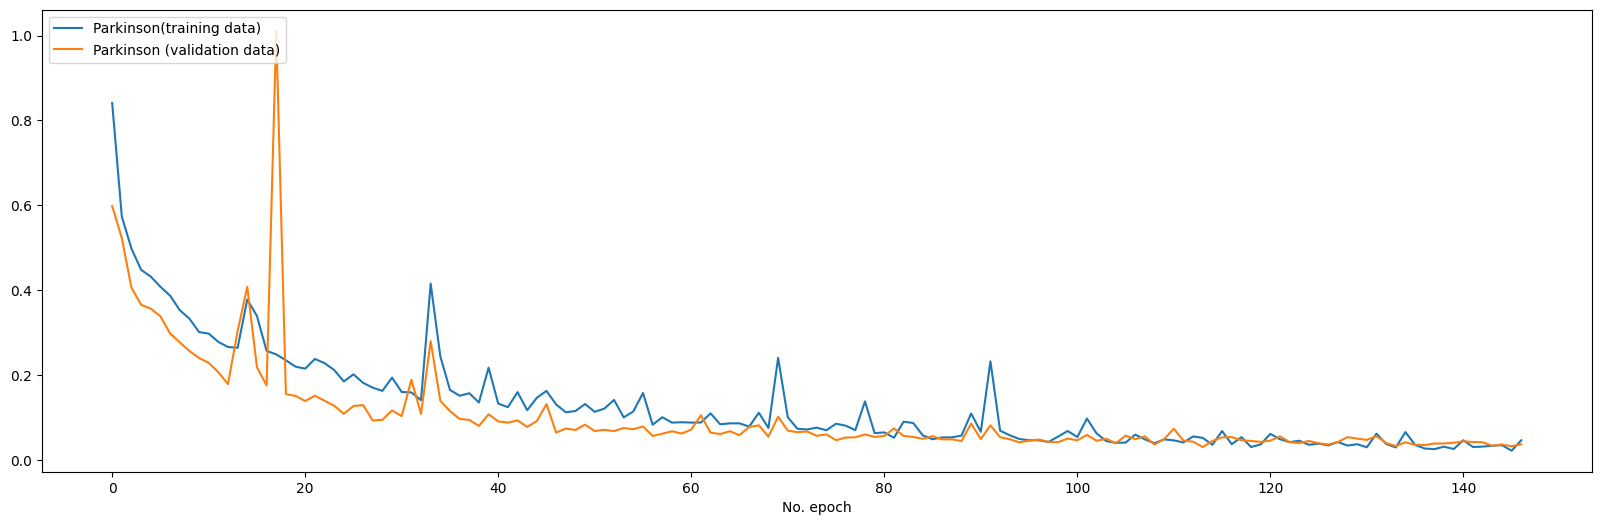

In [30]:
plt.plot(history.history['loss'], label='Parkinson(training data)')
plt.plot(history.history['val_loss'], label='Parkinson (validation data)')
plt.title('')
plt.ylabel('')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [31]:
max(history.history['val_accuracy'])

0.9927367568016052

In [32]:
max(history.history['accuracy'])

0.9926638603210449

In [33]:
min(history.history['loss'])

0.02122127264738083

In [34]:
min(history.history['val_loss'])

0.02986801415681839

In [35]:
pdt=model.predict(X_scaled_arr_test)

In [36]:
pdt1=model.predict(X_scaled_arr_test)
pdt1.size
classes_x1 = np.zeros((len(pdt1)))
for x in range(len(pdt1)):
  if(pdt1[x]>0.5):
    classes_x1[x]=(1)
  else:
    classes_x1[x]=(0)
#   print(x,end=" ")
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_arr_test,classes_x1 )

In [41]:
pdt1=model.predict(X_scaled_arr_test)
pdt1.size
classes_x1 = np.zeros((len(pdt1)))
for x in range(len(pdt1)):
  if(pdt1[x]>0.5):
    classes_x1[x]=(1)
  else:
    classes_x1[x]=(0)
#   print(x,end=" ")
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_arr_test,classes_x1 )

In [38]:
accuracy

0.9908203578898443

In [42]:
accuracy

0.9909365558912386

In [ ]:
# classes_x=np.argmax(pdt,axis=1) 
pdt.size
classes_x = np.zeros((len(pdt)))

In [ ]:
for x in range(len(pdt)):
  if(pdt[x]>0.5):
    classes_x[x]=(1)
  else:
    classes_x[x]=(0)
#   print(x,end=" ")

In [ ]:
print(Y_arr_test.size)
classes_x.size

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_arr_test,classes_x )

In [ ]:
accuracy

In [ ]:
m1=tf.keras.models.load_model('./Model/model_LSTM22.v')

In [ ]:
pdt=m1.predict(X_scaled_arr_test)

In [ ]:
for x in range(len(pdt)):
  if(pdt[x]>0.5):
    classes_x[x]=(1)
  else:
    classes_x[x]=(0)
#   print(x,end=" ")

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_arr_test,classes_x )

In [ ]:
accuracy

In [43]:
history = model.fit(X_scaled_arr_train,Y_arr_train,epochs=500,validation_split=0.4,batch_size=10,shuffle=True,callbacks=[early_stopping, checkpoint])

Epoch 1/500
2066/2066 [==============================] - 158s 76ms/step - loss: 0.0228 - accuracy: 0.9939 - val_loss: 0.0335 - val_accuracy: 0.9934

Epoch 00001: val_accuracy did not improve from 0.99484
Epoch 2/500
2066/2066 [==============================] - 158s 77ms/step - loss: 0.2527 - accuracy: 0.9653 - val_loss: 0.0616 - val_accuracy: 0.9863

Epoch 00002: val_accuracy did not improve from 0.99484
Epoch 3/500
2066/2066 [==============================] - 157s 76ms/step - loss: 0.1276 - accuracy: 0.9810 - val_loss: 0.1679 - val_accuracy: 0.9773

Epoch 00003: val_accuracy did not improve from 0.99484
Epoch 4/500
2066/2066 [==============================] - 158s 76ms/step - loss: 0.0993 - accuracy: 0.9845 - val_loss: 0.0755 - val_accuracy: 0.9869

Epoch 00004: val_accuracy did not improve from 0.99484
Epoch 5/500
2066/2066 [==============================] - 158s 77ms/step - loss: 0.0466 - accuracy: 0.9902 - val_loss: 0.0414 - val_accuracy: 0.9906

Epoch 00005: val_accuracy did not i

In [40]:
history = model.fit(X_scaled_arr_train,Y_arr_train,epochs=500,validation_split=0.4,batch_size=10,shuffle=True,callbacks=[early_stopping, checkpoint])

Epoch 1/500
2066/2066 [==============================] - 156s 76ms/step - loss: 0.0366 - accuracy: 0.9896 - val_loss: 0.0276 - val_accuracy: 0.9920

Epoch 00001: val_accuracy did not improve from 0.99484
Epoch 2/500
2066/2066 [==============================] - 158s 76ms/step - loss: 0.0359 - accuracy: 0.9908 - val_loss: 0.0360 - val_accuracy: 0.9916

Epoch 00002: val_accuracy did not improve from 0.99484
Epoch 3/500
2066/2066 [==============================] - 157s 76ms/step - loss: 0.0285 - accuracy: 0.9900 - val_loss: 0.0279 - val_accuracy: 0.9924

Epoch 00003: val_accuracy did not improve from 0.99484
Epoch 4/500
2066/2066 [==============================] - 157s 76ms/step - loss: 0.0412 - accuracy: 0.9905 - val_loss: 0.0291 - val_accuracy: 0.9931

Epoch 00004: val_accuracy did not improve from 0.99484
Epoch 5/500
2066/2066 [==============================] - 158s 77ms/step - loss: 0.0239 - accuracy: 0.9923 - val_loss: 0.0330 - val_accuracy: 0.9919

Epoch 00005: val_accuracy did not i

In [45]:
model1 = Sequential()
model1.add(Bidirectional(LSTM(80, dropout=0.3, 
                  return_sequences=True, 
                  input_shape=(X_scaled_arr_train.shape[1], X_scaled_arr_train.shape[2]))))
model1.add(Bidirectional(LSTM(32, dropout=0.5,return_sequences=True)))
model1.add(LSTM(24, dropout=0.2,return_sequences=True))
model1.add(LSTM(12, dropout=0.2,return_sequences=False))
model1.add(Dense(1, kernel_initializer='glorot_uniform', activation='relu'))
opt=tf.keras.optimizers.Adam(
    learning_rate=0.00005,
    name="Adam"
    )
model1.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, mode='auto')
checkpoint = ModelCheckpoint("./Model/model_LSTM_150.v", 
                             monitor='val_accuracy', verbose=1, save_best_only=True, 
                             save_weights_only=False)

In [46]:
history1 = model1.fit(X_scaled_arr_train,Y_arr_train,epochs=500,validation_split=0.1,batch_size=25,shuffle=True,callbacks=[early_stopping, checkpoint])

Epoch 1/500
1240/1240 [==============================] - 88s 65ms/step - loss: 1.3158 - accuracy: 0.4436 - val_loss: 0.6140 - val_accuracy: 0.6897

Epoch 00001: val_accuracy improved from -inf to 0.68972, saving model to ./Model/model_LSTM_150.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


Epoch 2/500
1240/1240 [==============================] - 82s 66ms/step - loss: 0.6159 - accuracy: 0.6873 - val_loss: 0.5799 - val_accuracy: 0.7089

Epoch 00002: val_accuracy improved from 0.68972 to 0.70889, saving model to ./Model/model_LSTM_150.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


Epoch 3/500
1240/1240 [==============================] - 81s 66ms/step - loss: 0.5754 - accuracy: 0.7134 - val_loss: 0.5230 - val_accuracy: 0.7603

Epoch 00003: val_accuracy improved from 0.70889 to 0.76031, saving model to ./Model/model_LSTM_150.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


Epoch 4/500
1240/1240 [==============================] - 82s 66ms/step - loss: 0.5303 - accuracy: 0.7504 - val_loss: 0.4769 - val_accuracy: 0.7786

Epoch 00004: val_accuracy improved from 0.76031 to 0.77862, saving model to ./Model/model_LSTM_150.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


Epoch 5/500
1240/1240 [==============================] - 81s 65ms/step - loss: 0.4767 - accuracy: 0.7890 - val_loss: 0.4451 - val_accuracy: 0.8379

Epoch 00005: val_accuracy improved from 0.77862 to 0.83788, saving model to ./Model/model_LSTM_150.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


Epoch 6/500
1240/1240 [==============================] - 82s 66ms/step - loss: 0.4567 - accuracy: 0.8093 - val_loss: 0.3691 - val_accuracy: 0.8611

Epoch 00006: val_accuracy improved from 0.83788 to 0.86113, saving model to ./Model/model_LSTM_150.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


Epoch 7/500
1240/1240 [==============================] - 81s 66ms/step - loss: 0.4031 - accuracy: 0.8387 - val_loss: 0.4107 - val_accuracy: 0.8318

Epoch 00007: val_accuracy did not improve from 0.86113
Epoch 8/500
1240/1240 [==============================] - 82s 66ms/step - loss: 0.3979 - accuracy: 0.8499 - val_loss: 0.3094 - val_accuracy: 0.8902

Epoch 00008: val_accuracy improved from 0.86113 to 0.89018, saving model to ./Model/model_LSTM_150.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


Epoch 9/500
1240/1240 [==============================] - 82s 66ms/step - loss: 0.3614 - accuracy: 0.8620 - val_loss: 0.2869 - val_accuracy: 0.8951

Epoch 00009: val_accuracy improved from 0.89018 to 0.89512, saving model to ./Model/model_LSTM_150.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


Epoch 10/500
1240/1240 [==============================] - 81s 66ms/step - loss: 0.3314 - accuracy: 0.8793 - val_loss: 0.2495 - val_accuracy: 0.9137

Epoch 00010: val_accuracy improved from 0.89512 to 0.91371, saving model to ./Model/model_LSTM_150.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


Epoch 11/500
1240/1240 [==============================] - 82s 66ms/step - loss: 0.3480 - accuracy: 0.8704 - val_loss: 0.2822 - val_accuracy: 0.8995

Epoch 00011: val_accuracy did not improve from 0.91371
Epoch 12/500
1240/1240 [==============================] - 82s 66ms/step - loss: 0.3061 - accuracy: 0.8978 - val_loss: 0.3235 - val_accuracy: 0.9166

Epoch 00012: val_accuracy improved from 0.91371 to 0.91662, saving model to ./Model/model_LSTM_150.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


Epoch 13/500
1240/1240 [==============================] - 83s 67ms/step - loss: 0.2809 - accuracy: 0.9091 - val_loss: 0.2244 - val_accuracy: 0.9274

Epoch 00013: val_accuracy improved from 0.91662 to 0.92737, saving model to ./Model/model_LSTM_150.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


Epoch 14/500
1240/1240 [==============================] - 82s 66ms/step - loss: 0.2579 - accuracy: 0.9146 - val_loss: 0.2133 - val_accuracy: 0.9343

Epoch 00014: val_accuracy improved from 0.92737 to 0.93434, saving model to ./Model/model_LSTM_150.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


Epoch 15/500
1240/1240 [==============================] - 82s 66ms/step - loss: 0.2545 - accuracy: 0.9186 - val_loss: 0.2008 - val_accuracy: 0.9335

Epoch 00015: val_accuracy did not improve from 0.93434
Epoch 16/500
1240/1240 [==============================] - 81s 66ms/step - loss: 0.3106 - accuracy: 0.8894 - val_loss: 0.2439 - val_accuracy: 0.9277

Epoch 00016: val_accuracy did not improve from 0.93434
Epoch 17/500
1240/1240 [==============================] - 81s 65ms/step - loss: 0.2457 - accuracy: 0.9236 - val_loss: 0.1805 - val_accuracy: 0.9451

Epoch 00017: val_accuracy improved from 0.93434 to 0.94509, saving model to ./Model/model_LSTM_150.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


Epoch 18/500
1240/1240 [==============================] - 82s 66ms/step - loss: 0.2393 - accuracy: 0.9256 - val_loss: 0.3777 - val_accuracy: 0.9184

Epoch 00018: val_accuracy did not improve from 0.94509
Epoch 19/500
1240/1240 [==============================] - 82s 66ms/step - loss: 0.3340 - accuracy: 0.8823 - val_loss: 0.2256 - val_accuracy: 0.9460

Epoch 00019: val_accuracy improved from 0.94509 to 0.94596, saving model to ./Model/model_LSTM_150.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


Epoch 20/500
1240/1240 [==============================] - 82s 66ms/step - loss: 0.2179 - accuracy: 0.9320 - val_loss: 0.1843 - val_accuracy: 0.9497

Epoch 00020: val_accuracy improved from 0.94596 to 0.94974, saving model to ./Model/model_LSTM_150.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


Epoch 21/500
1240/1240 [==============================] - 81s 66ms/step - loss: 0.2177 - accuracy: 0.9337 - val_loss: 0.2732 - val_accuracy: 0.9393

Epoch 00021: val_accuracy did not improve from 0.94974
Epoch 22/500
1240/1240 [==============================] - 81s 65ms/step - loss: 0.2173 - accuracy: 0.9349 - val_loss: 0.1498 - val_accuracy: 0.9593

Epoch 00022: val_accuracy improved from 0.94974 to 0.95933, saving model to ./Model/model_LSTM_150.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


Epoch 23/500
1240/1240 [==============================] - 81s 65ms/step - loss: 0.5145 - accuracy: 0.8609 - val_loss: 0.1726 - val_accuracy: 0.9497

Epoch 00023: val_accuracy did not improve from 0.95933
Epoch 24/500
1240/1240 [==============================] - 82s 66ms/step - loss: 0.2175 - accuracy: 0.9336 - val_loss: 0.1666 - val_accuracy: 0.9553

Epoch 00024: val_accuracy did not improve from 0.95933
Epoch 25/500
1240/1240 [==============================] - 81s 65ms/step - loss: 0.1935 - accuracy: 0.9423 - val_loss: 0.1420 - val_accuracy: 0.9622

Epoch 00025: val_accuracy improved from 0.95933 to 0.96223, saving model to ./Model/model_LSTM_150.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


Epoch 26/500
1240/1240 [==============================] - 81s 65ms/step - loss: 0.1796 - accuracy: 0.9453 - val_loss: 0.1576 - val_accuracy: 0.9631

Epoch 00026: val_accuracy improved from 0.96223 to 0.96310, saving model to ./Model/model_LSTM_150.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


Epoch 27/500
1240/1240 [==============================] - 80s 65ms/step - loss: 0.1929 - accuracy: 0.9438 - val_loss: 0.2421 - val_accuracy: 0.9192

Epoch 00027: val_accuracy did not improve from 0.96310
Epoch 28/500
1240/1240 [==============================] - 81s 65ms/step - loss: 0.2274 - accuracy: 0.9233 - val_loss: 0.1319 - val_accuracy: 0.9605

Epoch 00028: val_accuracy did not improve from 0.96310
Epoch 29/500
1240/1240 [==============================] - 80s 65ms/step - loss: 0.1851 - accuracy: 0.9428 - val_loss: 0.1689 - val_accuracy: 0.9657

Epoch 00029: val_accuracy improved from 0.96310 to 0.96572, saving model to ./Model/model_LSTM_150.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


Epoch 30/500
1240/1240 [==============================] - 81s 65ms/step - loss: 0.1734 - accuracy: 0.9488 - val_loss: 0.2102 - val_accuracy: 0.9329

Epoch 00030: val_accuracy did not improve from 0.96572
Epoch 31/500
1240/1240 [==============================] - 81s 65ms/step - loss: 0.2098 - accuracy: 0.9383 - val_loss: 0.1221 - val_accuracy: 0.9712

Epoch 00031: val_accuracy improved from 0.96572 to 0.97124, saving model to ./Model/model_LSTM_150.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


Epoch 32/500
1240/1240 [==============================] - 81s 66ms/step - loss: 0.1931 - accuracy: 0.9416 - val_loss: 0.1728 - val_accuracy: 0.9590

Epoch 00032: val_accuracy did not improve from 0.97124
Epoch 33/500
1240/1240 [==============================] - 81s 65ms/step - loss: 0.1556 - accuracy: 0.9527 - val_loss: 0.2048 - val_accuracy: 0.9648

Epoch 00033: val_accuracy did not improve from 0.97124
Epoch 34/500
1240/1240 [==============================] - 81s 65ms/step - loss: 0.1772 - accuracy: 0.9513 - val_loss: 0.1618 - val_accuracy: 0.9736

Epoch 00034: val_accuracy improved from 0.97124 to 0.97356, saving model to ./Model/model_LSTM_150.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


Epoch 35/500
1240/1240 [==============================] - 81s 65ms/step - loss: 0.1623 - accuracy: 0.9518 - val_loss: 0.1221 - val_accuracy: 0.9753

Epoch 00035: val_accuracy improved from 0.97356 to 0.97531, saving model to ./Model/model_LSTM_150.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


Epoch 36/500
1240/1240 [==============================] - 82s 66ms/step - loss: 0.1571 - accuracy: 0.9551 - val_loss: 0.1265 - val_accuracy: 0.9704

Epoch 00036: val_accuracy did not improve from 0.97531
Epoch 37/500
1240/1240 [==============================] - 81s 65ms/step - loss: 0.1781 - accuracy: 0.9550 - val_loss: 0.0951 - val_accuracy: 0.9756

Epoch 00037: val_accuracy improved from 0.97531 to 0.97560, saving model to ./Model/model_LSTM_150.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


Epoch 38/500
1240/1240 [==============================] - 81s 65ms/step - loss: 0.1511 - accuracy: 0.9597 - val_loss: 0.2049 - val_accuracy: 0.9518

Epoch 00038: val_accuracy did not improve from 0.97560
Epoch 39/500
1240/1240 [==============================] - 81s 65ms/step - loss: 0.1478 - accuracy: 0.9582 - val_loss: 0.1564 - val_accuracy: 0.9669

Epoch 00039: val_accuracy did not improve from 0.97560
Epoch 40/500
1240/1240 [==============================] - 81s 65ms/step - loss: 0.1414 - accuracy: 0.9626 - val_loss: 0.1110 - val_accuracy: 0.9788

Epoch 00040: val_accuracy improved from 0.97560 to 0.97879, saving model to ./Model/model_LSTM_150.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


Epoch 41/500
1240/1240 [==============================] - 81s 65ms/step - loss: 0.1418 - accuracy: 0.9607 - val_loss: 0.1360 - val_accuracy: 0.9768

Epoch 00041: val_accuracy did not improve from 0.97879
Epoch 42/500
1240/1240 [==============================] - 80s 65ms/step - loss: 0.1296 - accuracy: 0.9640 - val_loss: 0.0816 - val_accuracy: 0.9785

Epoch 00042: val_accuracy did not improve from 0.97879
Epoch 43/500
1240/1240 [==============================] - 80s 65ms/step - loss: 0.1846 - accuracy: 0.9518 - val_loss: 0.1029 - val_accuracy: 0.9817

Epoch 00043: val_accuracy improved from 0.97879 to 0.98170, saving model to ./Model/model_LSTM_150.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


Epoch 44/500
1240/1240 [==============================] - 82s 66ms/step - loss: 0.1157 - accuracy: 0.9690 - val_loss: 0.0991 - val_accuracy: 0.9814

Epoch 00044: val_accuracy did not improve from 0.98170
Epoch 45/500
1240/1240 [==============================] - 81s 65ms/step - loss: 0.1031 - accuracy: 0.9722 - val_loss: 0.0792 - val_accuracy: 0.9817

Epoch 00045: val_accuracy did not improve from 0.98170
Epoch 46/500
1240/1240 [==============================] - 82s 66ms/step - loss: 0.1296 - accuracy: 0.9629 - val_loss: 0.0693 - val_accuracy: 0.9831

Epoch 00046: val_accuracy improved from 0.98170 to 0.98315, saving model to ./Model/model_LSTM_150.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


Epoch 47/500
1240/1240 [==============================] - 81s 65ms/step - loss: 0.1537 - accuracy: 0.9610 - val_loss: 0.0890 - val_accuracy: 0.9840

Epoch 00047: val_accuracy improved from 0.98315 to 0.98402, saving model to ./Model/model_LSTM_150.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


Epoch 48/500
1240/1240 [==============================] - 81s 66ms/step - loss: 0.0897 - accuracy: 0.9743 - val_loss: 0.0627 - val_accuracy: 0.9866

Epoch 00048: val_accuracy improved from 0.98402 to 0.98664, saving model to ./Model/model_LSTM_150.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


Epoch 49/500
1240/1240 [==============================] - 82s 66ms/step - loss: 0.1078 - accuracy: 0.9720 - val_loss: 0.0721 - val_accuracy: 0.9814

Epoch 00049: val_accuracy did not improve from 0.98664
Epoch 50/500
1240/1240 [==============================] - 81s 65ms/step - loss: 0.1082 - accuracy: 0.9710 - val_loss: 0.1054 - val_accuracy: 0.9794

Epoch 00050: val_accuracy did not improve from 0.98664
Epoch 51/500
1240/1240 [==============================] - 80s 65ms/step - loss: 0.0897 - accuracy: 0.9737 - val_loss: 0.0611 - val_accuracy: 0.9840

Epoch 00051: val_accuracy did not improve from 0.98664
Epoch 52/500
1240/1240 [==============================] - 81s 65ms/step - loss: 0.0910 - accuracy: 0.9763 - val_loss: 0.0847 - val_accuracy: 0.9826

Epoch 00052: val_accuracy did not improve from 0.98664
Epoch 53/500
1240/1240 [==============================] - 81s 65ms/step - loss: 0.0944 - accuracy: 0.9771 - val_loss: 0.0691 - val_accuracy: 0.9849

Epoch 00053: val_accuracy did not i

INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


Epoch 65/500
1240/1240 [==============================] - 81s 65ms/step - loss: 0.0737 - accuracy: 0.9813 - val_loss: 0.0641 - val_accuracy: 0.9858

Epoch 00065: val_accuracy did not improve from 0.98693
Epoch 66/500
1240/1240 [==============================] - 81s 66ms/step - loss: 0.0649 - accuracy: 0.9813 - val_loss: 0.0958 - val_accuracy: 0.9834

Epoch 00066: val_accuracy did not improve from 0.98693
Epoch 67/500
1240/1240 [==============================] - 82s 66ms/step - loss: 0.0662 - accuracy: 0.9818 - val_loss: 0.0634 - val_accuracy: 0.9872

Epoch 00067: val_accuracy improved from 0.98693 to 0.98722, saving model to ./Model/model_LSTM_150.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


Epoch 68/500
1240/1240 [==============================] - 81s 65ms/step - loss: 0.0674 - accuracy: 0.9816 - val_loss: 0.0876 - val_accuracy: 0.9829

Epoch 00068: val_accuracy did not improve from 0.98722
Epoch 69/500
1240/1240 [==============================] - 81s 65ms/step - loss: 0.0711 - accuracy: 0.9794 - val_loss: 0.0703 - val_accuracy: 0.9881

Epoch 00069: val_accuracy improved from 0.98722 to 0.98809, saving model to ./Model/model_LSTM_150.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


Epoch 70/500
1240/1240 [==============================] - 82s 66ms/step - loss: 0.0832 - accuracy: 0.9787 - val_loss: 0.0503 - val_accuracy: 0.9869

Epoch 00070: val_accuracy did not improve from 0.98809
Epoch 71/500
1240/1240 [==============================] - 81s 66ms/step - loss: 0.0654 - accuracy: 0.9809 - val_loss: 0.0556 - val_accuracy: 0.9863

Epoch 00071: val_accuracy did not improve from 0.98809
Epoch 72/500
1240/1240 [==============================] - 82s 66ms/step - loss: 0.0622 - accuracy: 0.9820 - val_loss: 0.0645 - val_accuracy: 0.9863

Epoch 00072: val_accuracy did not improve from 0.98809
Epoch 73/500
1240/1240 [==============================] - 82s 66ms/step - loss: 0.0649 - accuracy: 0.9823 - val_loss: 0.0675 - val_accuracy: 0.9831

Epoch 00073: val_accuracy did not improve from 0.98809
Epoch 74/500
1240/1240 [==============================] - 81s 66ms/step - loss: 0.0770 - accuracy: 0.9796 - val_loss: 0.0795 - val_accuracy: 0.9823

Epoch 00074: val_accuracy did not i

INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


Epoch 76/500
1240/1240 [==============================] - 81s 66ms/step - loss: 0.0829 - accuracy: 0.9794 - val_loss: 0.0503 - val_accuracy: 0.9878

Epoch 00076: val_accuracy did not improve from 0.99128
Epoch 77/500
1240/1240 [==============================] - 82s 66ms/step - loss: 0.0526 - accuracy: 0.9857 - val_loss: 0.0512 - val_accuracy: 0.9887

Epoch 00077: val_accuracy did not improve from 0.99128
Epoch 78/500
1240/1240 [==============================] - 82s 66ms/step - loss: 0.0761 - accuracy: 0.9821 - val_loss: 0.0519 - val_accuracy: 0.9884

Epoch 00078: val_accuracy did not improve from 0.99128
Epoch 79/500
1240/1240 [==============================] - 81s 66ms/step - loss: 0.0538 - accuracy: 0.9858 - val_loss: 0.0487 - val_accuracy: 0.9875

Epoch 00079: val_accuracy did not improve from 0.99128
Epoch 80/500
1240/1240 [==============================] - 81s 66ms/step - loss: 0.0554 - accuracy: 0.9839 - val_loss: 0.0493 - val_accuracy: 0.9866

Epoch 00080: val_accuracy did not i

INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


Epoch 94/500
1240/1240 [==============================] - 81s 66ms/step - loss: 0.0535 - accuracy: 0.9839 - val_loss: 0.0434 - val_accuracy: 0.9904

Epoch 00094: val_accuracy did not improve from 0.99216
Epoch 95/500
1240/1240 [==============================] - 81s 65ms/step - loss: 0.0436 - accuracy: 0.9880 - val_loss: 0.0401 - val_accuracy: 0.9898

Epoch 00095: val_accuracy did not improve from 0.99216
Epoch 96/500
1240/1240 [==============================] - 81s 66ms/step - loss: 0.0411 - accuracy: 0.9878 - val_loss: 0.0375 - val_accuracy: 0.9910

Epoch 00096: val_accuracy did not improve from 0.99216
Epoch 97/500
1240/1240 [==============================] - 81s 65ms/step - loss: 0.0901 - accuracy: 0.9785 - val_loss: 0.0537 - val_accuracy: 0.9881

Epoch 00097: val_accuracy did not improve from 0.99216
Epoch 98/500
1240/1240 [==============================] - 81s 66ms/step - loss: 0.0479 - accuracy: 0.9876 - val_loss: 0.0490 - val_accuracy: 0.9884

Epoch 00098: val_accuracy did not i

In [47]:
history2 = model1.fit(X_scaled_arr_train,Y_arr_train,epochs=500,validation_split=0.2,batch_size=40,shuffle=True,callbacks=[early_stopping, checkpoint])

Epoch 1/500
689/689 [==============================] - 49s 71ms/step - loss: 0.0340 - accuracy: 0.9898 - val_loss: 0.0207 - val_accuracy: 0.9943

Epoch 00001: val_accuracy improved from 0.99216 to 0.99433, saving model to ./Model/model_LSTM_150.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


Epoch 2/500
689/689 [==============================] - 47s 69ms/step - loss: 0.0314 - accuracy: 0.9909 - val_loss: 0.0187 - val_accuracy: 0.9943

Epoch 00002: val_accuracy did not improve from 0.99433
Epoch 3/500
689/689 [==============================] - 48s 70ms/step - loss: 0.0308 - accuracy: 0.9915 - val_loss: 0.0190 - val_accuracy: 0.9943

Epoch 00003: val_accuracy did not improve from 0.99433
Epoch 4/500
689/689 [==============================] - 48s 70ms/step - loss: 0.0283 - accuracy: 0.9915 - val_loss: 0.0269 - val_accuracy: 0.9935

Epoch 00004: val_accuracy did not improve from 0.99433
Epoch 5/500
689/689 [==============================] - 48s 70ms/step - loss: 0.0369 - accuracy: 0.9899 - val_loss: 0.0216 - val_accuracy: 0.9930

Epoch 00005: val_accuracy did not improve from 0.99433
Epoch 6/500
689/689 [==============================] - 48s 69ms/step - loss: 0.0304 - accuracy: 0.9907 - val_loss: 0.0212 - val_accuracy: 0.9945

Epoch 00006: val_accuracy improved from 0.99433 to

INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM_150.v/assets


Epoch 7/500
689/689 [==============================] - 48s 70ms/step - loss: 0.0317 - accuracy: 0.9911 - val_loss: 0.0239 - val_accuracy: 0.9935

Epoch 00007: val_accuracy did not improve from 0.99448
Epoch 8/500
689/689 [==============================] - 48s 69ms/step - loss: 0.0699 - accuracy: 0.9855 - val_loss: 0.0492 - val_accuracy: 0.9869

Epoch 00008: val_accuracy did not improve from 0.99448
Epoch 9/500
689/689 [==============================] - 48s 69ms/step - loss: 0.1242 - accuracy: 0.9710 - val_loss: 0.1103 - val_accuracy: 0.9727

Epoch 00009: val_accuracy did not improve from 0.99448
Epoch 10/500
689/689 [==============================] - 48s 69ms/step - loss: 0.0628 - accuracy: 0.9842 - val_loss: 0.0579 - val_accuracy: 0.9887

Epoch 00010: val_accuracy did not improve from 0.99448
Epoch 11/500
689/689 [==============================] - 48s 69ms/step - loss: 0.0394 - accuracy: 0.9881 - val_loss: 0.0380 - val_accuracy: 0.9919

Epoch 00011: val_accuracy did not improve from 0